## import fgm tables


In [ ]:
!pip install gdown
!mkdir ./data
import gdown

def data_import():
  ids = {
      "tables_of_fgm.h5":"1XHPF7hUqT-zp__qkGwHg8noRazRnPqb0"
  }

  url = 'https://drive.google.com/uc?id='

  for title, g_id in ids.items(): 
    try:
      output_file = open("/content/data/" + title, 'wb')
      gdown.download(url + g_id, output_file, quiet=False)
    except IOError as e:
      print(e, file=sys.stderr)
    finally:
      output_file.close()
      
data_import()

Downloading...
From: https://drive.google.com/uc?id=1XHPF7hUqT-zp__qkGwHg8noRazRnPqb0
To: <_io.BufferedWriter name='/content/tables_of_fgm.h5'>
982MB [00:06, 153MB/s]


# Function libaries

## ResBlock

```res_block``` is the backbone of the resnet structure.

In [233]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Input, BatchNormalization, Dropout
from tensorflow.keras import layers


def res_block(input_tensor, n_neuron, stage, block, bn=False):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Dense(7 * n_neuron, name=conv_name_base + '2a')(input_tensor)
    if bn:
        x = BatchNormalization(axis=-1, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)
    x = Dropout(0.)(x)

    x = Dense(n_neuron, name=conv_name_base + '2b')(x)
    if bn:
        x = BatchNormalization(axis=-1, name=bn_name_base + '2b')(x)
    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    x = Dropout(0.)(x)

    return x

## data_reader
The ```read_h5_data``` function read the table from the hdf5 file. 

In the FGM case we chose not to scale the input features, since they all falls between 0 and 1. There are a great variety in the output features. In the reaction region close to stoichiometry the gradient in the output properties are great. A good example is the source term for progress variable, which rises from 0 to 1e5. So the output features are first transformed to logrithmic scale and then rearranged between  0 and 1. The outputs are normalised by its variance. This way the output value will be large where the gradient is great. So during training more focus would be put. The same 'focus design' has been put on the loss function selection as well. mse is selected over mae for that the squared error put more weights on the data samples that shows great changes. 

In [114]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler


class data_scaler(object):
    def __init__(self):
        self.norm = None
        self.norm_1 = None
        self.std = None
        self.case = None
        self.scale = 1
        self.bias = 1e-20
#         self.bias = 1


        self.switcher = {
            'std': 'std',
            'std2': 'std2',
            'std_min':'std_min',
            'min': 'min',
            'no':'no',
            'log': 'log',
            'log_min':'log_min',
            'log2': 'log2',
            'tan': 'tan'
        }

    def fit_transform(self, input_data, case):
        self.case = case
        if self.switcher.get(self.case) == 'std':
            self.norm = MinMaxScaler()
            self.norm_1 = MinMaxScaler()
            self.std = StandardScaler()
            out = self.norm_1.fit_transform(input_data)
            out = self.std.fit_transform(out)
            out = self.norm.fit_transform(out)

        if self.switcher.get(self.case) == 'std2':
            self.std = StandardScaler()
            out = self.std.fit_transform(input_data)

        if self.switcher.get(self.case) == 'std_min':
            self.norm = MinMaxScaler()
            self.std = StandardScaler()
            out = self.std.fit_transform(input_data)
            out = self.norm.fit_transform(out)

        if self.switcher.get(self.case) == 'min':
            self.norm = MinMaxScaler()
            out = self.norm.fit_transform(input_data)

        if self.switcher.get(self.case) == 'no':
            self.norm = MinMaxScaler()
            self.std = StandardScaler()
            out = input_data

        if self.switcher.get(self.case) == 'log':
            out = - np.log(np.asarray(input_data / self.scale) + self.bias)
            self.std = StandardScaler()
            out = self.std.fit_transform(out)

        if self.switcher.get(self.case) == 'log_min':
            out = - np.log(np.asarray(input_data / self.scale) + self.bias)
            self.norm = MinMaxScaler()
            out = self.norm.fit_transform(out)

        if self.switcher.get(self.case) == 'log2':
            self.norm = MinMaxScaler()
            self.norm_1 = MinMaxScaler()
            out = self.norm.fit_transform(input_data)
            out = np.log(np.asarray(out) + self.bias)
            out = self.norm_1.fit_transform(out)

        if self.switcher.get(self.case) == 'tan':
            self.norm = MaxAbsScaler()
            self.std = StandardScaler()
            out = self.std.fit_transform(input_data)
            out = self.norm.fit_transform(out)
            out = np.tan(out / (2 * np.pi + self.bias))

        return out

    def transform(self, input_data):
        if self.switcher.get(self.case) == 'std':
            out = self.norm_1.transform(input_data)
            out = self.std.transform(out)
            out = self.norm.transform(out)

        if self.switcher.get(self.case) == 'std2':
            out = self.std.transform(input_data)

        if self.switcher.get(self.case) == 'std_min':
            out = self.std.transform(input_data)
            out = self.norm.transform(out)

        if self.switcher.get(self.case) == 'min':
            out = self.norm.transform(input_data)

        if self.switcher.get(self.case) == 'no':
            out = input_data

        if self.switcher.get(self.case) == 'log':
            out = - np.log(np.asarray(input_data / self.scale) + self.bias)
            out = self.std.transform(out)

        if self.switcher.get(self.case) == 'log_min':
            out = - np.log(np.asarray(input_data / self.scale) + self.bias)
            out = self.norm.transform(out)

        if self.switcher.get(self.case) == 'log2':
            out = self.norm.transform(input_data)
            out = np.log(np.asarray(out) + self.bias)
            out = self.norm_1.transform(out)

        if self.switcher.get(self.case) == 'tan':
            out = self.std.transform(input_data)
            out = self.norm.transform(out)
            out = np.tan(out / (2 * np.pi + self.bias))

        return out

    def inverse_transform(self, input_data):

        if self.switcher.get(self.case) == 'std':
            out = self.norm.inverse_transform(input_data)
            out = self.std.inverse_transform(out)
            out = self.norm_1.inverse_transform(out)

        if self.switcher.get(self.case) == 'std2':
            out = self.std.inverse_transform(input_data)

        if self.switcher.get(self.case) == 'std_min':
            out = self.norm.inverse_transform(input_data)
            out = self.std.inverse_transform(out)

        if self.switcher.get(self.case) == 'min':
            out = self.norm.inverse_transform(input_data)

        if self.switcher.get(self.case) == 'no':
            out = input_data

        if self.switcher.get(self.case) == 'log':
            out = self.std.inverse_transform(input_data)
            out = (np.exp(-out) - self.bias) * self.scale

        if self.switcher.get(self.case) == 'log_min':
            out = self.norm.inverse_transform(input_data)
            out = (np.exp(-out) - self.bias) * self.scale

        if self.switcher.get(self.case) == 'log2':
            out = self.norm_1.inverse_transform(input_data)
            out = np.exp(out) - self.bias
            out = self.norm.inverse_transform(out)

        if self.switcher.get(self.case) == 'tan':
            out = (2 * np.pi + self.bias) * np.arctan(input_data)
            out = self.norm.inverse_transform(out)
            out = self.std.inverse_transform(out)

        return out
      

def read_h5_data(fileName, input_features, labels):
    df = pd.read_hdf(fileName)

    input_df=df[input_features]
    in_scaler = data_scaler()
    input_np = in_scaler.fit_transform(input_df.values,'no')

    label_df=df[labels].clip(0)
#     if 'PVs' in labels:
#       label_df['PVs']=np.log(label_df['PVs']+1)
    out_scaler = data_scaler()
    label_np = out_scaler.fit_transform(label_df.values,'std2')

    return input_np, label_np, df, in_scaler, out_scaler

# model

## load data

In [115]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# define the labels

# labels = ['T','PVs']
labels = ['T','CH4','O2','CO2','CO','H2O','H2','OH','PVs']
# labels = ['C2H3', 'C2H6', 'CH2', 'H2CN', 'C2H4', 'H2O2', 'C2H',
#           'CN', 'heatRelease', 'NCO', 'NNH', 'N2', 'AR', 'psi', 'CO', 'CH4',
#           'HNCO', 'CH2OH', 'HCCO', 'CH2CO', 'CH', 'mu', 'C2H2', 'C2H5', 'H2',
#           'T','PVs', 'O', 'O2', 'N2O', 'C', 'C3H7', 'CH2(S)', 'NH3', 'HO2',
#           'NO','HCO', 'NO2', 'OH', 'HCNO', 'CH3CHO', 'CH3', 'NH', 'alpha', 'CH3O',
#           'CO2', 'CH3OH', 'CH2CHO', 'CH2O', 'C3H8', 'HNO', 'NH2', 'HCN', 'H',
#           'N','H2O', 'HCCOH', 'HCNN']

input_features=['f','pv','zeta']

# read in the data
x_input, y_label, df, in_scaler, out_scaler = read_h5_data('./data/tables_of_fgm.h5',input_features=input_features, labels = labels)

## build neural network model

In [240]:
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import ModelCheckpoint

# split into train and test data
x_train, x_test, y_train, y_test = train_test_split(x_input,y_label, test_size=0.01)

n_neuron = 20
# %%
print('set up ANN')
# ANN parameters
dim_input = x_train.shape[1]
dim_label = y_train.shape[1]

batch_norm = False

# This returns a tensor
inputs = Input(shape=(dim_input,),name='input_1')

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(n_neuron, activation='relu')(inputs)

# less then 2 res_block, there will be variance
x = res_block(x, n_neuron, stage=1, block='a', bn=batch_norm)
x = res_block(x, n_neuron, stage=1, block='b', bn=batch_norm)

predictions = Dense(dim_label, activation='linear', name='output_1')(x)

model = Model(inputs=inputs, outputs=predictions)
model.summary()

set up ANN
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
dense_60 (Dense)                (None, 20)           80          input_1[0][0]                    
__________________________________________________________________________________________________
res1a_branch2a (Dense)          (None, 140)          2940        dense_60[0][0]                   
__________________________________________________________________________________________________
activation_120 (Activation)     (None, 140)          0           res1a_branch2a[0][0]             
__________________________________________________________________________________________________

# model training 

## gpu training

In [155]:
import keras.backend as K

def cubic_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred)*K.abs(y_true - y_pred), axis=-1)

In [235]:
from tensorflow.keras import optimizers

batch_size = 1024*32
epochs = 3000
vsplit = 0.2

loss_type='mse'

adam_op = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999,epsilon=1e-8, decay=0.0, amsgrad=True)

model.compile(loss=loss_type, optimizer=adam_op, metrics=['accuracy'])
# model.compile(loss=cubic_loss, optimizer=adam_op, metrics=['accuracy'])

# checkpoint (save the best model based validate loss)
filepath = "./weights.best.cntk.hdf5"

checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             period=20)

callbacks_list = [checkpoint]

# fit the model
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=vsplit,
    verbose=2,
    callbacks=callbacks_list,
    shuffle=True)

model.save('trained_fgm_nn.H5')

Train on 1987927 samples, validate on 496982 samples
Epoch 1/3000
 - 13s - loss: 0.6425 - acc: 0.4852 - val_loss: 0.3626 - val_acc: 0.6667
Epoch 2/3000
 - 1s - loss: 0.2655 - acc: 0.7656 - val_loss: 0.2039 - val_acc: 0.8450
Epoch 3/3000
 - 1s - loss: 0.1763 - acc: 0.8678 - val_loss: 0.1583 - val_acc: 0.8771
Epoch 4/3000
 - 1s - loss: 0.1458 - acc: 0.8806 - val_loss: 0.1366 - val_acc: 0.8837
Epoch 5/3000
 - 1s - loss: 0.1285 - acc: 0.8865 - val_loss: 0.1217 - val_acc: 0.8903
Epoch 6/3000
 - 2s - loss: 0.1150 - acc: 0.8925 - val_loss: 0.1088 - val_acc: 0.8959
Epoch 7/3000
 - 1s - loss: 0.1032 - acc: 0.8971 - val_loss: 0.0980 - val_acc: 0.8985
Epoch 8/3000
 - 1s - loss: 0.0927 - acc: 0.9004 - val_loss: 0.0878 - val_acc: 0.8983
Epoch 9/3000
 - 1s - loss: 0.0832 - acc: 0.9048 - val_loss: 0.0786 - val_acc: 0.9049
Epoch 10/3000
 - 1s - loss: 0.0757 - acc: 0.9110 - val_loss: 0.0728 - val_acc: 0.9086
Epoch 11/3000
 - 2s - loss: 0.0681 - acc: 0.9172 - val_loss: 0.0634 - val_acc: 0.9200
Epoch 12/

## TPU training

In [ ]:
import os


batch_size = 1024*128
epochs = 100
vsplit = 0.2

tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)

tpu_model.compile(
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-4),
    loss=tf.keras.losses.mae,
    metrics=['accuracy']
)


tpu_model.fit(
    X_train,y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=vsplit
)

## Training loss plot

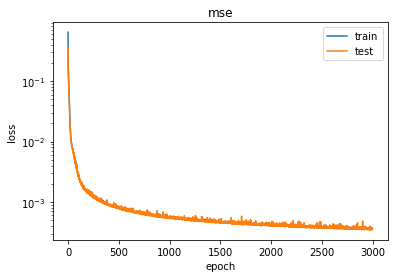

In [236]:
fig = plt.figure()
plt.semilogy(history.history['loss'])
if vsplit:
    plt.semilogy(history.history['val_loss'])
plt.title(loss_type)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Inference test

## prepare frontend for plotting

In [6]:
#@title import plotly
import plotly.plotly as py
import numpy as np
from plotly.offline import init_notebook_mode, iplot
# from plotly.graph_objs import Contours, Histogram2dContour, Marker, Scatter
import plotly.graph_objs as go

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

## prepare data for plotting

## TPU data prepare

In [ ]:
cpu_model = tpu_model.sync_to_cpu()
predict_val=cpu_model.predict(X_test)

X_test_df = pd.DataFrame(in_scaler.inverse_transform(X_test),columns=input_features)
y_test_df = pd.DataFrame(out_scaler.inverse_transform(y_test),columns=labels)

predict_val = model.predict(X_test)
predict_df = pd.DataFrame(out_scaler.inverse_transform(predict_val), columns=labels)

test_data=pd.concat([X_test_df,y_test_df],axis=1)
pred_data=pd.concat([X_test_df,predict_df],axis=1)

test_data.to_hdf('sim_check.H5',key='test')
pred_data.to_hdf('sim_check.H5',key='pred')

df_test=pd.read_hdf('sim_check.H5',key='test')
df_pred=pd.read_hdf('sim_check.H5',key='pred')
zeta_level=list(set(df_test['zeta']))
zeta_level.sort()

## GPU data prepare

In [237]:
model.load_weights("./weights.best.cntk.hdf5")

x_test_df = pd.DataFrame(in_scaler.inverse_transform(x_test),columns=input_features)
y_test_df = pd.DataFrame(out_scaler.inverse_transform(y_test),columns=labels)

predict_val = model.predict(x_test,batch_size=1024)
predict_df = pd.DataFrame(out_scaler.inverse_transform(predict_val), columns=labels)

test_data=pd.concat([x_test_df,y_test_df],axis=1)
pred_data=pd.concat([x_test_df,predict_df],axis=1)

!rm sim_check.h5
test_data.to_hdf('sim_check.h5',key='test')
pred_data.to_hdf('sim_check.h5',key='pred')

df_test=pd.read_hdf('sim_check.h5',key='test')
df_pred=pd.read_hdf('sim_check.h5',key='pred')

zeta_level=list(set(df_test['zeta']))
zeta_level.sort()

## interactive plot

In [239]:
#@title Default title text
species = 'PVs' #@param {type:"string"}

# configure_plotly_browser_state()
# init_notebook_mode(connected=False)

df_t=df_test.loc[df_test['zeta']==zeta_level[1]].sample(frac=0.5)
# df_p=df_pred.loc[df_pred['zeta']==zeta_level[1]].sample(frac=0.1)
df_p=df_pred.loc[df_t.index]
error=df_p[species]-df_t[species]

fig_db = {
    'data': [       
        {'name':'test data from table',
         'x': df_t['f'],
         'y': df_t['pv'],
         'z': df_t[species],
         'type':'scatter3d', 
        'mode': 'markers',
          'marker':{
              'size':1
          }
        },
        {'name':'prediction from neural networks',
         'x': df_p['f'],
         'y': df_p['pv'],
         'z': df_p[species],
         'type':'scatter3d', 
        'mode': 'markers',
          'marker':{
              'size':1
          },
        },
        {'name':'error in difference',
         'x': df_p['f'],
         'y': df_p['pv'],
         'z': error,
         'type':'scatter3d', 
         'mode': 'markers',
          'marker':{
              'size':1
          },
         }       
    ],
    'layout': {
        'scene':{
            'xaxis': {'title':'mixture fraction'},
            'yaxis': {'title':'progress variable'},
            'zaxis': {'title': species}
                 }
    }
}
# iplot(fig_db, filename='multiple-scatter')
iplot(fig_db)

In [ ]:
layout

{'xaxis': {}}

In [ ]:
df_p['T']

18339     428.306366
23275    1208.719971
20617     366.667419
5958      701.695251
15998     982.646790
8221      675.589355
13357    1170.622437
3399      889.169128
24295     385.650757
12075    1484.524414
7608      405.936981
24011    1151.844116
11403     786.547485
13271     426.226440
16204     568.691162
15927     645.248779
22713     296.786682
22123     813.945801
10851     534.735168
12908     662.818970
23080     340.972839
16938     734.988220
11526     770.892273
7217      465.167877
18529     319.734619
7708      307.078308
20460    1065.076904
20437     429.436035
11856     364.320374
14885     364.325592
            ...     
16824     619.481079
9652      776.821411
10779     663.060486
9430      544.365601
5217      510.356903
19653    1194.823120
10845     342.816040
10388     697.538940
16396     285.287170
6163      463.656250
3318     1012.577393
8281      516.662964
21290     805.862122
19184     353.660919
4134      729.435059
12471     366.944794
7578      471

In [ ]:
df_t.shape

(1225, 12)